# XGBoost BaseLine Model - Supervised ML

We'll us XGBoost (eXtreme Gradient Boosting) for price movement prediction (Classification) using the Features and Labels we engineered.

## 1. Load Data and Select Labels

In [1]:
import pandas as pd
import numpy as np

stock_data = pd.read_csv('../data/ML_data/Stryker_ML_Ready_dataset.csv',parse_dates=['Date'])

print(stock_data.columns)

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_20', 'SMA_50',
       'EMA_12', 'EMA_26', 'RSI', 'MACD', 'Signal_Line', 'MACD_Hist',
       'BB_Middle', 'BB_Upper', 'BB_Lower', 'OBV', 'OBV_pct_change',
       'Volume_rolling_mean_10', 'Volume_pct_change', 'Volume_spike',
       'Volume_zscore', 'Daily_Return', 'Log_Return', 'Next_Return',
       'Target_Binary', 'Target_MultiClass', 'Target_Regression',
       'Max_3D_Close', 'Target_3D'],
      dtype='object')


- **Price Trend Indicators**
    - SMA_20, SMA_50 – trend-following

    - EMA_12, EMA_26 – faster reaction to recent price

- **Momentum & Oscillators**
    - RSI – oversold/overbought momentum

    - MACD, Signal_Line, MACD_Hist – trend reversals

- **Volatility**
    - BB_Middle, BB_Upper, BB_Lower – price envelope

    - Log_Return, Daily_Return – price velocity

-  **Volume-Based**
    - OBV, OBV_pct_change – money flow

    - Volume_rolling_mean_10, Volume_pct_change, Volume_spike, Volume_zscore

In [2]:
# Label: Binary Price Movement
target_col = 'Target_Binary'

# Drop Rows where Label is Missing

stock_data = stock_data.dropna(subset=[target_col])

In [3]:
stock_data.head()

,Date,Close,High,Low,Open,Volume,SMA_20,SMA_50,EMA_12,EMA_26,...,Volume_spike,Volume_zscore,Daily_Return,Log_Return,Next_Return,Target_Binary,Target_MultiClass,Target_Regression,Max_3D_Close,Target_3D
0,2023-05-22,280.647339,285.992144,280.196195,281.039613,1189700,275.318704,283.637429,280.647339,280.647339,...,False,-1.023136,-0.041968,-0.042874,-0.041968,0,-1,-0.041968,280.647339,0
1,2023-05-23,268.869110,279.794109,266.819448,278.862460,2163300,275.318704,283.637429,278.835304,279.774877,...,False,-1.023136,-0.041968,-0.042874,-0.005836,0,0,-0.005836,268.869110,0
2,2023-05-24,267.299957,269.830184,264.995303,267.731468,1181800,275.318704,283.637429,277.060635,278.850809,...,False,-1.023136,-0.005836,-0.005853,-0.000587,0,0,-0.000587,267.319611,1
3,2023-05-25,267.143066,268.829874,262.592627,267.790333,1159100,275.318704,283.637429,275.534855,277.983569,...,False,-1.023136,-0.000587,-0.000587,0.000661,1,0,0.000661,267.319611,1
4,2023-05-26,267.319611,270.526524,266.093734,267.819778,1091700,275.318704,283.637429,274.270971,277.193646,...,False,-1.023136,0.000661,0.000661,-0.003999,0,0,-0.003999,270.261780,1


## 2. Define Features & Labels

XGBoost baseline model is  built using purely price- and volume-derived features (technical indicators).we are missing full 2 years of sentiment data (We're using Free NewsAPI). Sentiment Data can collect daily and can be built over the time.

In [30]:
# Select Features
baseline_features = ['SMA_20', 'SMA_50','EMA_12', 'EMA_26',
            'RSI',
            'MACD',
            'OBV', 
            'Volume_rolling_mean_10', 
            'Daily_Return']

X = stock_data[baseline_features]
y = stock_data['Target_Binary']

## 3. Chronological Train/Test Split

We wouldn't use random splitting — we'll use time-based split to avoid leakage.

In [31]:
from sklearn.model_selection import train_test_split

# Sort by time
stock_data.sort_values(by='Date' if 'Date' in stock_data.columns else stock_data.columns[0], inplace=True)

split_index = int(0.8 * len(stock_data))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

## 4.Train XGBoost Classifier

In [26]:
#pip install xgboost

In [32]:
from xgboost import XGBClassifier

model =XGBClassifier(n_estimators =100,
                    learning_rate = 0.1,
                    max_depth=6,
                    random_state = 42,
                    use_label_encoder = False,
                    eval_metric = 'logloss')

model.fit(X_train, y_train)
print("✅ XGBoost Model Trained")

✅ XGBoost Model Trained


## 5. Evaluate Model Performance

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix ,classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

print('Accuracy:' , accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

Accuracy: 0.57
              precision    recall  f1-score   support

           0       0.55      0.65      0.60        49
           1       0.60      0.49      0.54        51

    accuracy                           0.57       100
   macro avg       0.57      0.57      0.57       100
weighted avg       0.57      0.57      0.57       100



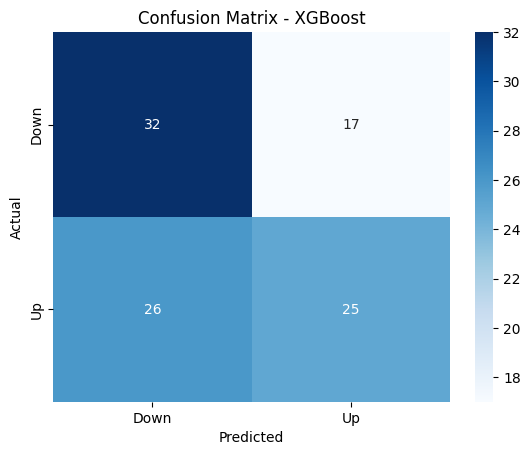

In [34]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

 **Summary of Results**
| Metric                         | Value                     |
| ------------------------------ | ------------------------- |
| **Accuracy**                   | 0.57                      |
| **Precision** (Class 1 - Up)   | 0.60                      |
| **Recall** (Class 1 - Up)      | 0.49                      |
| **F1-Score** (Class 1)         | 0.54                      |
| **Precision** (Class 0 - Down) | 0.55                      |
| **Recall** (Class 0 - Down)    | 0.65                      |
| **Support**                    | Balanced (49 down, 51 up) |


**Summary of BaseLine Model**
- Overall performance is better than random (0.50) — indicating the model is learning useful patterns from technical indicators.

- The model:

    - Is more precise when predicting “Up” days (fewer false positives)

    - Misses some actual Up days (lower recall for class 1)

    - Is slightly better at catching Down days (recall 0.65 for class 0)


- We're using 9 technical features (SMA, EMA, MACD, RSI, OBV, volume, returns).

- The model has learned to distinguish between Up and Down movements with moderate accuracy.

- This is a strong baseline in finance where even 55–60% accuracy is valuable.

- With some enhancements (like lagged features, sentiment, and thresholding), this can become a production-ready signal.



<Figure size 1000x600 with 0 Axes>

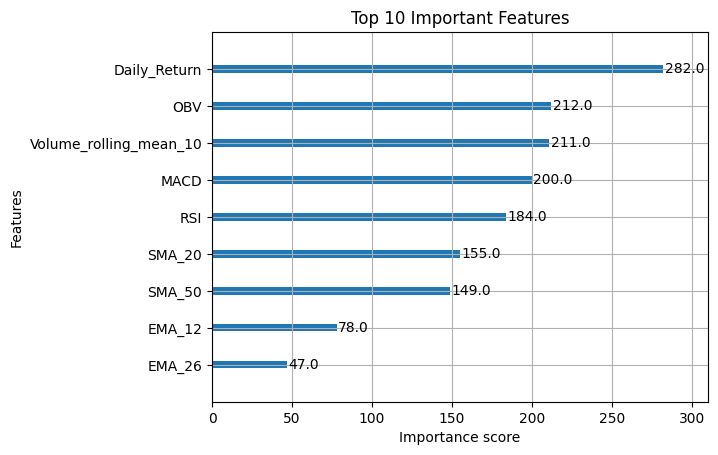

In [37]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(10,6))
plot_importance(model, max_num_features=10)
plt.title('Top 10 Important Features')
plt.show()